In [ ]:
# Brief: import common libraries and frameworks
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from utilities3 import LpLoss
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.model_selection import train_test_split
from functools import reduce
from functools import partial
import operator
from timeit import default_timer
from matplotlib.ticker import FormatStrFormatter
import deepxde as dde
# Import kernel solver functions from external module
from kernel_solvers import solver_2x2, K_solver_2x2

In [33]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import pchip_interpolate
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.integrate import trapz

# from scipy import sparse
from math import atan2, pi, sin, cos, sqrt

## cal system parameters and funcions

In [ ]:
class Struct:
    pass

# System configuration
sys = Struct()
sys.ctrl_on = 1
sys.RGB_color1 = [1, 0, 0]
sys.RGB_color2 = [0, 0, 1]
sys.RGB_color3 = [0, 1, 0]
sys.style1 = '--'
sys.style2 = '-.'
sys.style3 = '-'

# Simulation parameters
# Parameter values
vm = 40  # m/s 
rm = 0.16  # 240 
tau = 60  # s
L = 500  # m 1km
T = 300  # second /hour
rs = 0.12 # veh/mile
Veq = lambda rho: vm * (1 - rho/rm)
vs = Veq(rs)
gamma = 1
qs = rs * vs # per second
ps = vm/rm * qs/vs

# Adding to sys
sys.vs = vs
sys.rs = rs
sys.ps = ps
sys.gamma = gamma
sys.L = L
sys.tau = tau
sys.qs = qs

# System parameters
fun = Struct()
fun.lam = lambda x: 1*x + vs - x
fun.mu = lambda x: 1*x + gamma*ps - vs - x
fun.lam_d = lambda x: 1*x - x
fun.mu_d = lambda x: 1*x - x
fun.c_1 = lambda x: 1*x - x
fun.c_2 = lambda x: -1/tau * np.exp(-x/(tau*vs))
fun.q = (vs - gamma*ps)/vs
sys.fun = fun
sys.N = 100
sys.N_grid = sys.N + 2
sys.N_g = 100
sys.simH = T
sys.h = 0.1
sys.Tspan = np.arange(0, sys.simH+sys.h, sys.h)
sys.Delta = L / (sys.N + 1)
sys.xspan = np.linspace(0, L, sys.N_grid)
sys.xspanT = np.arange(sys.Delta, L - sys.Delta + sys.h, sys.Delta)
sys.intArr = sys.Delta * np.hstack((0.5, np.ones(sys.N), 0.5))
sys.lam = fun.lam(sys.xspan)
sys.mu = fun.mu(sys.xspan)
sys.c_1 = fun.c_1(sys.xspan)
sys.c_2 = fun.c_2(sys.xspan)
sys.q = fun.q
sys.t_1 = np.dot(sys.intArr, 1/sys.lam)
sys.t_2 = np.dot(sys.intArr, 1/sys.mu)
sys.t_F = sys.t_1 + sys.t_2
sys.gamma_U = 1

In [38]:
# Parameters
epochs =1000
ntrain = 900
ntest = 100
batch_size = 20
learning_rate = 0.0001
step_size= 200
gamma4learning = 0.1


X = sys.L
dx = sys.Delta
nx = sys.N_grid
grids = []
grid = np.linspace(0, sys.L, sys.N_grid, dtype=np.float32).reshape(sys.N_grid,1)
grid = torch.from_numpy(grid).cuda()

In [39]:
ndata = 1000
x = np.loadtxt("x_1.dat", dtype=np.float32)
y = np.loadtxt("y_1.dat", dtype=np.float32)

In [40]:
y = y.reshape(y.shape[0], y.shape[1])
x = x.reshape(x.shape[0], x.shape[1])
x = np.array(x, dtype=np.float32).reshape(ndata, sys.N_grid)
y = np.array(y, dtype=np.float32).reshape(ndata, sys.N*(sys.N+1))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)
trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=False, generator=torch.Generator(device = 'cuda'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device = 'cuda'))


In [41]:
def count_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [42]:
# Define a sequential torch network for batch and trunk. Can use COV2D which we will show later
dim_x = 1
m = 102
branch = [m, 256, 256]
trunk = [dim_x, 128, 256]
activation = "relu"
kernel = "Glorot normal"

class DeepONetModified(nn.Module):
    def __init__(self, branch, trunk, activation, kernel, projection):
        super(DeepONetModified, self).__init__()
        self.net1 = dde.nn.DeepONetCartesianProd(branch, trunk, activation, kernel)
        self.fc1 = nn.Linear(102, 200)
        self.fc2 = nn.Linear(200, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 1024)
        self.fc6 = nn.Linear(1024, projection)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x, grid = x[0], x[1]
        x = self.net1((x, grid))
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x
       
projection  = 10100
model = DeepONetModified(branch, trunk, activation, kernel, projection)
print(count_params(model))

11469549


## To chose train or load model

In [43]:
train_flag = 0

In [44]:
for x, y in trainData:
    x, y = x.cuda(), y.cuda()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma4learning)
loss = torch.nn.MSELoss()
# loss = torch.nn.KLDivLoss()
train_lossArr = []
test_lossArr = []
time_Arr = []
learning_rate

0.0001

In [46]:
if train_flag == 1:
    
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_loss = 0
        for x, y in trainData:
            x, y = x.cuda(), y.cuda()
            optimizer.zero_grad()
            out = model((x, grid))
            
            lp = loss(out, y)
            lp.backward()
            
            optimizer.step()
            train_loss += lp.item()
            
        scheduler.step()
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x, y in testData:
                x, y = x.cuda(), y.cuda()
                
                out = model((x, grid))
                test_loss += loss(out, y).item()
                
        train_loss /= len(trainData)
        test_loss /= len(testData)
        
        train_lossArr.append(train_loss)
        test_lossArr.append(test_loss)
        
        t2 = default_timer()
        time_Arr.append(t2-t1)
        np.savetxt('train_lossArr.dat', train_lossArr)
        np.savetxt('test_lossArr.dat', test_lossArr)
        if ep%50 == 0:
            print(ep, t2-t1, train_loss, test_loss)

else:
    model.load_state_dict(torch.load('muToKTorchModel_triu'))

In [47]:
if train_flag == 1:

    testLoss = 0
    trainLoss = 0
    with torch.no_grad():
        for x, y in trainData:
            x, y = x.cuda(), y.cuda()

            out = model((x, grid))
            out = out.reshape((out.shape[0], out.shape[1]))
            trainLoss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
            
        for x, y in testData:
            x, y = x.cuda(), y.cuda()

            out = model((x, grid))
            out = out.reshape((out.shape[0], out.shape[1]))
            testLoss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
        
        
    print("Avg Epoch Time:", sum(time_Arr)/len(time_Arr))
    print("Final Testing Loss:", testLoss)
    print("Final Training Loss:", trainLoss)

In [48]:
xdata = np.array(sys.mu, dtype=np.float32)
xdata = torch.from_numpy(xdata.reshape((1, m))).cuda()
ydata = model((xdata, grid))

In [ ]:
ydata_test = ydata.reshape(2, -1)
Kvu1_model = np.zeros((sys.N,sys.N))
Kvv1_model = np.zeros((sys.N,sys.N))
ydata_test = ydata_test.detach().cpu().numpy() 
Kvu1_model[np.triu_indices_from(Kvu1_model)] = ydata_test[0,:]
Kvv1_model[np.triu_indices_from(Kvv1_model)] = ydata_test[1,:]

sys.Kvu1_model = pchip_interpolate(np.linspace(0, sys.L, sys.N_g), Kvu1_model[:, -1], sys.xspan)
sys.Kvv1_model = pchip_interpolate(np.linspace(0, sys.L, sys.N_g), Kvv1_model[:, -1], sys.xspan)


## Sovle initial value problem

In [50]:
def ode_dynamic_model(x, t, sys):
    N = sys.N
    N_grid = sys.N_grid
    lam = sys.lam
    mu = sys.mu
    c_1 = sys.c_1
    c_2 = sys.c_2

    dummy = np.reshape(x[0:2*N], (N, 2), order='F')
    dummy_a = np.vstack([2*dummy[0, :] - dummy[1, :], dummy, 2*dummy[N-1, :] - dummy[N-2, :]])

    u_sf_a = dummy_a[:, 0]
    u_sf = u_sf_a[1:sys.N+1]
    v_sf_a = dummy_a[:,1]
    v_sf = v_sf_a[1:sys.N+1]
    U_sf_f = x[2*sys.N]

    if sys.ctrl_on == 1:
        U_sf = trapz(sys.Kvu1_model*u_sf_a, sys.xspan, axis=-1) + trapz(sys.Kvv1_model*v_sf_a, sys.xspan, axis=-1) - np.exp(-sys.L / (sys.tau * sys.vs)) * u_sf_a[sys.N_grid - 1]
    else:
        U_sf = 0
    u_sf_a[0] = sys.q * v_sf_a[0]
    v_sf_a[sys.N_grid - 1] = U_sf + np.exp(-sys.L / (sys.tau * sys.vs)) * u_sf_a[sys.N_grid - 1]

    u_sf_x = np.hstack([(u_sf_a[1] - u_sf_a[0]) / sys.Delta,
                        (u_sf_a[0:(N_grid - 3)] - 4 * u_sf_a[1:(N_grid - 2)] + 3 * u_sf_a[2:(N_grid - 1)]) / (
                                    2 * sys.Delta)])
    v_sf_x = np.hstack(
        [(-3 * v_sf_a[1:(N_grid - 2)] + 4 * v_sf_a[2:(N_grid - 1)] - v_sf_a[3:N_grid]) / (2 * sys.Delta),
         (v_sf_a[N_grid - 1] - v_sf_a[N_grid - 2]) / sys.Delta])

    u_sf_t = -lam[1:(N + 1)] * u_sf_x + c_1[1:(N + 1)] * v_sf
    v_sf_t = mu[1:(N + 1)] * v_sf_x + c_2[1:(N + 1)] * u_sf

    U_sf_f_t = sys.gamma_U * (U_sf - U_sf_f)

    dt = np.hstack([u_sf_t, v_sf_t, U_sf_f_t])

    return dt

In [51]:
# Load the pretrained model

def ode_dynamic(x, t, sys):
    N = sys.N
    N_grid = sys.N_grid
    lam = sys.lam
    mu = sys.mu
    c_1 = sys.c_1
    c_2 = sys.c_2

    dummy = np.reshape(x[0:2*N], (N, 2), order='F')
    dummy_a = np.vstack([2*dummy[0, :] - dummy[1, :], dummy, 2*dummy[N-1, :] - dummy[N-2, :]])

    u_sf_a = dummy_a[:, 0]
    u_sf = u_sf_a[1:sys.N+1]
    v_sf_a = dummy_a[:,1]
    v_sf = v_sf_a[1:sys.N+1]
    U_sf_f = x[2*sys.N]

    if sys.ctrl_on == 1:
        U_sf = trapz(sys.Kvu1*u_sf_a, sys.xspan, axis=-1) + trapz(sys.Kvv1*v_sf_a, sys.xspan, axis=-1) - np.exp(-sys.L / (sys.tau * sys.vs)) * u_sf_a[sys.N_grid - 1]
    else:
        U_sf = 0
    u_sf_a[0] = sys.q * v_sf_a[0]
    v_sf_a[sys.N_grid - 1] = U_sf + np.exp(-sys.L / (sys.tau * sys.vs)) * u_sf_a[sys.N_grid - 1]

    u_sf_x = np.hstack([(u_sf_a[1] - u_sf_a[0]) / sys.Delta,
                        (u_sf_a[0:(N_grid - 3)] - 4 * u_sf_a[1:(N_grid - 2)] + 3 * u_sf_a[2:(N_grid - 1)]) / (
                                    2 * sys.Delta)])
    v_sf_x = np.hstack(
        [(-3 * v_sf_a[1:(N_grid - 2)] + 4 * v_sf_a[2:(N_grid - 1)] - v_sf_a[3:N_grid]) / (2 * sys.Delta),
         (v_sf_a[N_grid - 1] - v_sf_a[N_grid - 2]) / sys.Delta])

    u_sf_t = -lam[1:(N + 1)] * u_sf_x + c_1[1:(N + 1)] * v_sf
    v_sf_t = mu[1:(N + 1)] * v_sf_x + c_2[1:(N + 1)] * u_sf

    U_sf_f_t = sys.gamma_U * (U_sf - U_sf_f)

    dt = np.hstack([u_sf_t, v_sf_t, U_sf_f_t])

    return dt

In [ ]:
def solve_PDE(ode_dynamic,initial_con,t_log,sysconfig):
    x_log, info = odeint(ode_dynamic, initial_con, t_log, args=(sysconfig,), full_output=True)
    numT = len(t_log)
    xx = np.reshape(x_log[:, 0:2*sys.N], (numT, 2*sys.N))
    u_sf = xx[:, 0:sys.N]
    v_sf = xx[:, sys.N:2*sys.N]
    u_sf_a = np.zeros((numT, sys.N + 2))
    v_sf_a = np.zeros((numT, sys.N + 2))
    u_sf_a[:, 0] = 2*u_sf[:, 0] - u_sf[:, 1]
    u_sf_a[:, -1] = 2*u_sf[:, -1] - u_sf[:, -2]
    u_sf_a[:, 1:sys.N+1] = u_sf

    v_sf_a[:, 0] = 2*v_sf[:, 0] - v_sf[:, 1]
    v_sf_a[:, -1] = 2*v_sf[:, -1] - v_sf[:, -2]
    v_sf_a[:, 1:sys.N+1] = v_sf
    
    v_sr_ori = v_sf * sys.gamma*sys.ps/sys.qs
    u_sf_mid = u_sf * np.exp(-sys.xspanT.transpose()/(sys.tau*sys.vs))
    u_sf_ori = u_sf_mid + sys.qs*(1/sys.vs - 1/(sys.gamma*sys.ps))*v_sr_ori

    q = u_sf_ori + sys.qs
    v = v_sr_ori + sys.vs
    rho = q/v

    v = v * 3.6
    rho = rho*1000
    U_sf = x_log[:, 2*sys.N]


    uv_sf_norm = np.sqrt(np.matmul(u_sf_a*u_sf_a, sys.intArr)) + np.sqrt(np.matmul(v_sf_a*v_sf_a, sys.intArr))
    return rho, v, U_sf, uv_sf_norm

In [53]:
u_sf_0 = np.exp(sys.xspanT/(sys.tau*sys.vs))*(0.1*np.sin(3*np.pi*sys.xspanT/L)*sys.qs - sys.qs*(1/sys.vs - 1/(sys.gamma*sys.ps))*(-0.1*np.sin(3*np.pi*sys.xspanT/sys.L)*sys.vs))
v_sf_0 = -0.1*np.sin(3*np.pi*sys.xspanT/sys.L)*sys.vs*sys.qs/(sys.gamma*sys.ps)


U_sf_f_0 = 0

x0 = np.hstack((u_sf_0, v_sf_0, U_sf_f_0))
# Solve the ODE system
t_log = sys.Tspan

In [54]:
rho, v, U_sf, uv_sf_norm = solve_PDE(ode_dynamic=ode_dynamic_model,initial_con=x0,t_log=t_log,sysconfig=sys)

## Posting processing

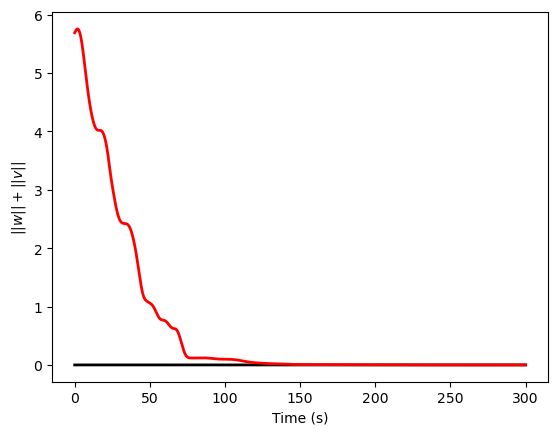

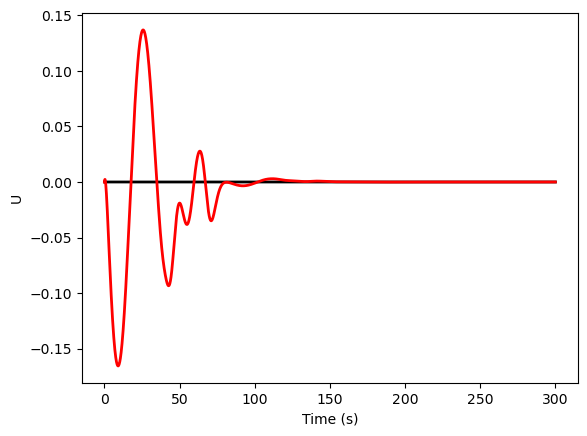

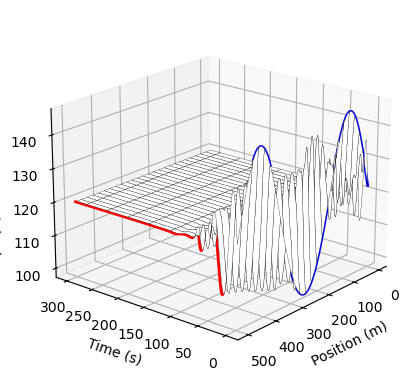

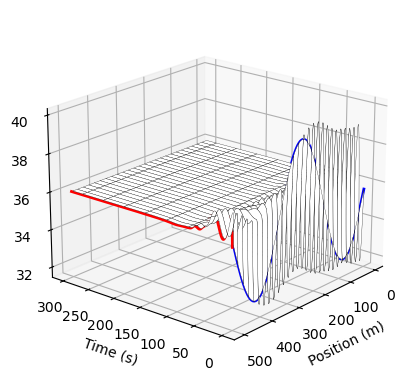

equilibrium density: 120.0 veh/km
equilibrium velocity: 36.0 km/h
equilibrium flow: 4320.0 veh/h
convergence time: 75.0 s


In [55]:
name = 'mu2K'
# Norm
fig = plt.figure()
plt.plot(t_log, np.zeros_like(t_log), 'k', linewidth=2)
plt.plot(t_log, uv_sf_norm, sys.style3, color=sys.RGB_color1, linewidth=2)
# plt.plot(t_log, uv_sf_norm_test, sys.style3, color=sys.RGB_color2, linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel(r'$||w||+||v||$')
# plt.savefig('image/'+name+'_w_v.pdf', dpi = 300)
plt.show()

# Actuation
fig = plt.figure()
plt.plot(t_log, np.zeros_like(t_log), 'k', linewidth=2)
plt.plot(t_log, U_sf, sys.style3, color=sys.RGB_color1, linewidth=2)
# plt.savefig('image/'+name+'_U.pdf', dpi = 300)
plt.xlabel('Time (s)')
plt.ylabel('U')
plt.show()


# Density evolution
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X_arr, T_arr = np.meshgrid(sys.xspanT, t_log)
# ax.plot_surface(X_arr, T_arr, rho, cmap='turbo')
ax.plot_surface(X_arr, T_arr, rho, edgecolor="black",lw=0.2, rstride=400, cstride=4, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
ax.plot(sys.xspanT, np.zeros_like(sys.xspanT), rho[0, :], color='blue', linewidth=2)
ax.plot([L]*len(t_log), t_log, rho[:, -1], color='red', linewidth=2)
ax.set_xlabel('Position (m)')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Density (veh/km)')
ax.view_init(elev=20, azim=-140)
ax.invert_xaxis()
# plt.savefig('image/'+name+'_Density.pdf', dpi = 300)
plt.show()

# Velocity evolution
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X_arr, T_arr = np.meshgrid(sys.xspanT, t_log)
# ax.plot_surface(X_arr, T_arr, v, cmap='turbo')
ax.plot_surface(X_arr, T_arr, v, edgecolor="black",lw=0.2, rstride=400, cstride=4, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
ax.plot(sys.xspanT, np.zeros_like(sys.xspanT), v[0, :], color='blue', linewidth=2)
ax.plot([L]*len(t_log), t_log, v[:, -1], color='red', linewidth=2)
ax.set_xlabel('Position (m)')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Velocity (km/h)')
ax.invert_xaxis()
ax.view_init(elev=20, azim=-140)
# plt.savefig('image/'+name+'_Velocity.pdf', dpi = 300)
plt.show()

print(f'equilibrium density: {sys.rs*1000} veh/km')
print(f'equilibrium velocity: {sys.vs*3.6} km/h')
print(f'equilibrium flow: {sys.qs*3600} veh/h')
print(f'convergence time: {sys.t_F} s')


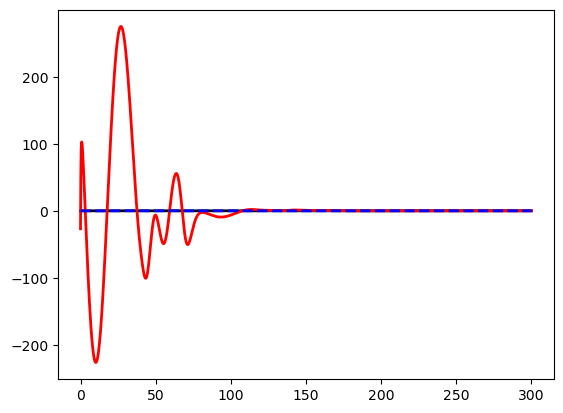

In [69]:
U_sf_test = U_sf*np.exp(-sys.L/(sys.tau*sys.vs)) +sys.qs*(1/sys.vs - 1/(sys.gamma*sys.ps))*(v[:,-1]/3.6-sys.vs)
U_sf_test = U_sf_test*3600
fig = plt.figure()
plt.plot(t_log, np.zeros_like(t_log), 'k', linewidth=2)
plt.plot(t_log, U_sf_test, sys.style3, color=sys.RGB_color1, linewidth=2)
plt.plot(t_log, U_sf, sys.style1, color=sys.RGB_color2, linewidth=2)